In [1]:
# üìå [Í∏∞Î≥∏ Ìå®ÌÇ§ÏßÄ ÏûÑÌè¨Ìä∏]
import os
import shutil
import torch
import ultralytics
from ultralytics import YOLO
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
from glob import glob
from collections import Counter
import threading

In [2]:
# üìå [1] GPU Î∞è ÌôòÍ≤Ω Ï≤¥ÌÅ¨
print("‚úÖ CUDA ÏÇ¨Ïö© Í∞ÄÎä•:", torch.cuda.is_available())
print("‚úÖ PyTorch Î≤ÑÏ†Ñ:", torch.__version__)
ultralytics.checks()

Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Setup complete  (24 CPUs, 31.7 GB RAM, 24.9/735.1 GB disk)


In [3]:
# üìå [2] Ïã§Ìå®Ìïú Ïù¥Ï†Ñ runs ÏÇ≠Ï†ú
def clean_incomplete_runs(base_dir='../code/runs/detect'):
    if not os.path.exists(base_dir):
        print(f"üìÇ '{base_dir}' Ìè¥ÎçîÍ∞Ä ÏóÜÏñ¥ ÏÇ≠Ï†ú ÏÉùÎûµ")
        return

    deleted = False
    for folder in os.listdir(base_dir):
        path = os.path.join(base_dir, folder)
        best_model = os.path.join(path, 'weights', 'best.pt')
        if not os.path.exists(best_model):
            print(f"üßπ ÏÇ≠Ï†ú ÎåÄÏÉÅ: {path}")
            shutil.rmtree(path)
            deleted = True

    if not deleted:
        print("‚úÖ ÏÇ≠Ï†úÌï† ÎØ∏ÏôÑÏÑ± run ÏóÜÏùå. Î™®Îì† runÏù¥ best.pt Ìè¨Ìï®.")

clean_incomplete_runs()

‚úÖ ÏÇ≠Ï†úÌï† ÎØ∏ÏôÑÏÑ± run ÏóÜÏùå. Î™®Îì† runÏù¥ best.pt Ìè¨Ìï®.


In [4]:
# üìå [3] Í∞ÄÏû• ÏµúÍ∑º run Í≤∞Í≥º ÏöîÏïΩ Ï∂úÎ†•
def get_last_run_csv():
    runs = sorted(glob('runs/detect/*/results.csv'), key=os.path.getmtime, reverse=True)
    if runs:
        print(f"üìÑ ÎßàÏßÄÎßâ ÌõàÎ†® Í≤∞Í≥º ÌååÏùº: {runs[0]}")
        df = pd.read_csv(runs[0])
        print("üîÅ ÎßàÏßÄÎßâ ÌõàÎ†® Í≤∞Í≥º (ÎßàÏßÄÎßâ 5Ï§Ñ):")
        print(df.tail())
    else:
        print("‚ÑπÔ∏è Ïù¥Ï†Ñ ÌõàÎ†® Í≤∞Í≥º ÏóÜÏùå.")

get_last_run_csv()

üìÑ ÎßàÏßÄÎßâ ÌõàÎ†® Í≤∞Í≥º ÌååÏùº: runs/detect\yolov11n_custom_002\results.csv
üîÅ ÎßàÏßÄÎßâ ÌõàÎ†® Í≤∞Í≥º (ÎßàÏßÄÎßâ 5Ï§Ñ):
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
25     26  6314.87         0.54487         1.42637         0.94978   
26     27  6539.40         0.55126         1.42283         0.95562   
27     28  6768.79         0.53685         1.39680         0.94422   
28     29  6998.81         0.54541         1.39211         0.94520   
29     30  7228.67         0.54086         1.38914         0.94671   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
25               0.91847            0.79311           0.87818   
26               0.91802            0.80232           0.88047   
27               0.92164            0.80678           0.88419   
28               0.91056            0.80861           0.88437   
29               0.92094            0.81296           0.88409   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl

In [5]:
# üìå [4] ÏûêÎèô ÎÑòÎ≤ÑÎßÅ run Ïù¥Î¶Ñ ÏÉùÏÑ±
def get_next_run_name(base_dir='runs/detect', prefix='yolov11n_custom'):
    i = 1
    while os.path.exists(os.path.join(base_dir, f'{prefix}_{i:03d}')):
        i += 1
    return f'{prefix}_{i:03d}'

run_name = get_next_run_name()
print(f"üöÄ ÏÉà ÌõàÎ†® run Ïù¥Î¶Ñ: {run_name}")

üöÄ ÏÉà ÌõàÎ†® run Ïù¥Î¶Ñ: yolov11n_custom_003


In [6]:
# üìå [5] ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ Ï∂úÎ†• Î∞è ÌÅ¥ÎûòÏä§Î≥Ñ Î†àÏù¥Î∏î Í∞úÏàò ÌôïÏù∏ Ìï®Ïàò Ï∂îÍ∞Ä
def get_dataset_info(img_dir, label_dir, class_names=None):
    img_files = glob(os.path.join(img_dir, '*.jpg'))
    label_files = glob(os.path.join(label_dir, '*.txt'))

    total_img_size = sum(os.path.getsize(f) for f in img_files)
    total_label_size = sum(os.path.getsize(f) for f in label_files)

    print(f"\nüìÅ Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú: {img_dir}")
    print(f"üñºÔ∏è Ïù¥ÎØ∏ÏßÄ Í∞úÏàò: {len(img_files)}")
    print(f"üíæ Ïù¥ÎØ∏ÏßÄ Ïö©Îüâ: {total_img_size / 1024 / 1024:.2f} MB")
    print(f"üìÑ ÎùºÎ≤® Í≤ΩÎ°ú: {label_dir}")
    print(f"üìù ÎùºÎ≤® Í∞úÏàò: {len(label_files)}")
    print(f"üíæ ÎùºÎ≤® Ïö©Îüâ: {total_label_size / 1024:.2f} KB")

    # ÌÅ¥ÎûòÏä§Î≥Ñ ÎùºÎ≤® Í∞úÏàò ÏßëÍ≥Ñ
    classes = []
    for f in label_files:
        with open(f, 'r') as file:
            lines = file.readlines()
            classes += [int(line.split()[0]) for line in lines if line.strip()]
    counter = Counter(classes)
    print(f"\nüìä ÌÅ¥ÎûòÏä§Î≥Ñ ÎùºÎ≤® Í∞úÏàò ({label_dir}):")
    if class_names:
        for cls_idx, count in sorted(counter.items()):
            print(f"  {cls_idx} ({class_names[cls_idx]}): {count}")
    else:
        print(counter)

# ÏòàÏãúÎ°ú data.yamlÏóêÏÑú ÌÅ¥ÎûòÏä§Î™Ö ÏùΩÏñ¥Ïò§Í∏∞
import yaml
with open('data.yaml', 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg.get('names', None)

get_dataset_info('../train/images', '../train/labels', class_names)
get_dataset_info('../valid/images', '../valid/labels', class_names)


üìÅ Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú: ../train/images
üñºÔ∏è Ïù¥ÎØ∏ÏßÄ Í∞úÏàò: 3530
üíæ Ïù¥ÎØ∏ÏßÄ Ïö©Îüâ: 67.55 MB
üìÑ ÎùºÎ≤® Í≤ΩÎ°ú: ../train/labels
üìù ÎùºÎ≤® Í∞úÏàò: 3530
üíæ ÎùºÎ≤® Ïö©Îüâ: 319.50 KB

üìä ÌÅ¥ÎûòÏä§Î≥Ñ ÎùºÎ≤® Í∞úÏàò (../train/labels):
  0 (Green Light): 542
  1 (Red Light): 585
  2 (Speed Limit 10): 19
  3 (Speed Limit 100): 267
  4 (Speed Limit 110): 101
  5 (Speed Limit 120): 252
  6 (Speed Limit 20): 285
  7 (Speed Limit 30): 334
  8 (Speed Limit 40): 235
  9 (Speed Limit 50): 283
  10 (Speed Limit 60): 301
  11 (Speed Limit 70): 318
  12 (Speed Limit 80): 323
  13 (Speed Limit 90): 168
  14 (Stop): 285

üìÅ Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú: ../valid/images
üñºÔ∏è Ïù¥ÎØ∏ÏßÄ Í∞úÏàò: 801
üíæ Ïù¥ÎØ∏ÏßÄ Ïö©Îüâ: 15.38 MB
üìÑ ÎùºÎ≤® Í≤ΩÎ°ú: ../valid/labels
üìù ÎùºÎ≤® Í∞úÏàò: 801
üíæ ÎùºÎ≤® Ïö©Îüâ: 69.86 KB

üìä ÌÅ¥ÎûòÏä§Î≥Ñ ÎùºÎ≤® Í∞úÏàò (../valid/labels):
  0 (Green Light): 122
  1 (Red Light): 108
  3 (Speed Limit 100): 52
  4 (Speed Limit 110): 17
  5 (Speed Limit 120): 60
  6 (Speed

In [7]:
# üìå Ï∫êÏãú ÌååÏùº ÏÇ≠Ï†ú Ìï®Ïàò
# def safe_delete_cache(path: str):
#     if not os.path.exists(path):
#         print(f"üü¢ Ï∫êÏãú ÌååÏùº ÏóÜÏùå (ÏÇ≠Ï†ú Î∂àÌïÑÏöî): {path}")
#         return

#     file_size = os.path.getsize(path)
#     last_modified = os.path.getmtime(path)
#     now = time.time()

#     should_delete = (
#         file_size < 1024 or  # 1KB Ïù¥Ìïò
#         (now - last_modified > 3600)  # 1ÏãúÍ∞Ñ Ïù¥ÏÉÅ Í≤ΩÍ≥º
#     )

#     if should_delete:
#         try:
#             os.remove(path)
#             print(f"‚úÖ Ï∫êÏãú ÏÇ≠Ï†ú ÏôÑÎ£å: {path}")
#         except Exception as e:
#             print(f"‚ùå Ï∫êÏãú ÏÇ≠Ï†ú Ïã§Ìå®: {path} ‚Üí {e}")
#     else:
#         print(f"üîí Ï∫êÏãú Ïú†ÏßÄ: {path} (Ï°∞Í±¥ ÎØ∏Ï∂©Ï°±)")

# safe_delete_cache(r"D:\Project\PJT_07\train\labels.cache")
# safe_delete_cache(r"D:\Project\PJT_07\valid\labels.cache")

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï£ºÍ∏∞Ï†ÅÏúºÎ°ú Ï∂úÎ†• (Í∞ÑÍ≤© 60Ï¥àÎ°ú Ï°∞Ï†ï)
def gpu_monitor():
    while True:
        if torch.cuda.is_available():
            mem_alloc = torch.cuda.memory_allocated() / 1024**2
            mem_reserved = torch.cuda.memory_reserved() / 1024**2
            print(f"[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: {mem_alloc:.1f}MB, ÏòàÏïΩ: {mem_reserved:.1f}MB")
        time.sleep(60)  # 60Ï¥à Í∞ÑÍ≤©

monitor_thread = threading.Thread(target=gpu_monitor, daemon=True)
monitor_thread.start()

# Î™®Îç∏ Î°úÎìú
model = YOLO('yolo11n.pt')
# model = YOLO('runs/detect/yolov11n_custom_001/weights/best.pt')  # Í∏∞Ï°¥ Î™®Îç∏ÏóêÏÑú Ïù¥Ïñ¥ÏÑú ÌïôÏäµ Ïãú

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Ìè¨Ìï®Ìïú train Ìï®Ïàò Ìò∏Ï∂ú
start_time = time.time()

model.train(
    data='data.yaml',
    epochs=30,
    imgsz=640,
    batch=8,
    name=run_name,
    device='0',
    workers=0,
    verbose=True  # Îçî ÏûêÏÑ∏Ìïú Î°úÍ∑∏ Ï∂úÎ†•
)

train_duration = time.time() - start_time
print(f"‚úÖ ÌõàÎ†® ÏÜåÏöî ÏãúÍ∞Ñ: {train_duration:.2f}Ï¥à")

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 0.0MB, ÏòàÏïΩ: 0.0MB
Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_custom_003, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

train: Scanning D:\Project\PJT_07\train\labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3530


val: Fast image access  (ping: 0.10.0 ms, read: 57.639.7 MB/s, size: 20.7 KB)


val: Scanning D:\Project\PJT_07\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 801/801


Plotting labels to runs\detect\yolov11n_custom_003\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov11n_custom_003
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.25G     0.9582      4.202      1.291         22        640:  31%|‚ñà‚ñà‚ñà       | 137/442 [00:42<01:07

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 142.3MB, ÏòàÏïΩ: 1278.0MB


       1/30      1.25G      0.863      3.558      1.191          9        640:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 437/442 [01:42<00:01

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 1036.7MB, ÏòàÏïΩ: 1278.0MB


       1/30      1.25G      0.862      3.549      1.191          4        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:43<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.202      0.398      0.247      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.43G     0.7875      2.717      1.108         20        640:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 243/442 [00:48<00:37

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 625.2MB, ÏòàÏïΩ: 1460.0MB


       2/30      1.44G     0.7975      2.622      1.114          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.331      0.462      0.376      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.44G      0.753      2.415      1.118         19        640:  11%|‚ñà         | 48/442 [00:09<01:18,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 868.1MB, ÏòàÏïΩ: 1476.0MB


       3/30      1.44G     0.7958      2.283      1.112         18        640:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 342/442 [01:09<00:19

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 220.5MB, ÏòàÏïΩ: 1476.0MB


       3/30      1.46G     0.7815      2.239      1.106          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:29<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.545      0.535      0.514      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.46G     0.7502      2.031      1.106         11        640:  33%|‚ñà‚ñà‚ñà‚ñé      | 145/442 [00:29<00:57

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1492.0MB


       4/30      1.47G     0.7461      1.938      1.084          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|‚ñâ         | 5/51 [00:

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 244.3MB, ÏòàÏïΩ: 1506.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.601      0.562      0.585      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.47G     0.7315      1.698      1.078         17        640:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 239/442 [00:50<00:42

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 1101.4MB, ÏòàÏïΩ: 1506.0MB


       5/30      1.47G     0.7282      1.698      1.071          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:33<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.647      0.579      0.668       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.47G     0.6607      1.572      1.051         11        640:   7%|‚ñã         | 29/442 [00:06<01:30,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 205.3MB, ÏòàÏïΩ: 1506.0MB


       6/30      1.47G     0.7024      1.526      1.053         16        640:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 302/442 [01:06<00:30

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 167.3MB, ÏòàÏïΩ: 1506.0MB


       6/30      1.47G     0.7037      1.502      1.055          4        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944       0.73      0.709      0.784       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.47G     0.7046      1.401      1.057         21        640:  18%|‚ñà‚ñä        | 79/442 [00:17<01:17,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 177.0MB, ÏòàÏïΩ: 1506.0MB


       7/30      1.47G        0.7      1.373      1.054         23        640:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 355/442 [01:17<00:19

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 167.3MB, ÏòàÏïΩ: 1506.0MB


       7/30      1.47G     0.6954      1.367      1.053          4        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.856      0.661      0.781      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.47G     0.6929       1.27      1.047         20        640:  31%|‚ñà‚ñà‚ñà       | 138/442 [00:30<01:06

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 182.5MB, ÏòàÏïΩ: 1506.0MB


       8/30      1.47G      0.678      1.265      1.046         24        640:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 412/442 [01:30<00:06

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 1105.1MB, ÏòàÏïΩ: 1506.0MB


       8/30      1.47G     0.6773       1.27      1.045          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.823        0.7      0.811      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.47G     0.6852      1.203      1.049         22        640:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 195/442 [00:42<00:56

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 187.6MB, ÏòàÏïΩ: 1506.0MB


       9/30      1.47G     0.6788      1.186      1.043          4        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 28/51 [00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 244.3MB, ÏòàÏïΩ: 1506.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.896      0.764      0.852      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.47G     0.6461      1.123      1.031         14        640:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 247/442 [00:54<00:42

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 908.9MB, ÏòàÏïΩ: 1506.0MB


      10/30      1.47G     0.6497      1.105      1.027          7        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.872      0.746      0.845      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.47G     0.6869      1.112      1.064         15        640:   7%|‚ñã         | 29/442 [00:06<01:29,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 250.8MB, ÏòàÏïΩ: 1506.0MB


      11/30      1.47G     0.6494       1.08      1.028         14        640:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 300/442 [01:06<00:32

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 212.8MB, ÏòàÏïΩ: 1506.0MB


      11/30      1.49G     0.6501      1.065      1.026          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.875      0.775      0.864      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.49G     0.6462      1.066      1.009         20        640:  20%|‚ñà‚ñà        | 89/442 [00:19<01:16,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 1034.2MB, ÏòàÏïΩ: 1522.0MB


      12/30      1.49G     0.6294      1.031       1.01         24        640:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 364/442 [01:19<00:17

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 152.1MB, ÏòàÏïΩ: 1522.0MB


      12/30      1.49G     0.6363      1.022      1.016          9        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.885      0.794      0.877      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.49G       0.62     0.9711      1.014         24        640:  32%|‚ñà‚ñà‚ñà‚ñè      | 143/442 [00:31<01:04

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 205.3MB, ÏòàÏïΩ: 1522.0MB


      13/30      1.49G     0.6326     0.9715       1.02         17        640:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 411/442 [01:31<00:07

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 157.3MB, ÏòàÏïΩ: 1522.0MB


      13/30      1.49G     0.6301     0.9739       1.02          3        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.929      0.771      0.888      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.49G     0.6216     0.9532      1.018         10        640:  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 198/442 [00:42<00:52

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 205.3MB, ÏòàÏïΩ: 1522.0MB


      14/30      1.49G     0.6233      0.942      1.014          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:36<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 33/51 [00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 266.3MB, ÏòàÏïΩ: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.904      0.805      0.894       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.49G     0.5958     0.8744      1.006         21        640:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 261/442 [00:56<00:38

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 182.5MB, ÏòàÏïΩ: 1522.0MB


      15/30      1.49G     0.6023     0.8813      1.008          6        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:35<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944       0.92       0.83      0.906      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.49G     0.6062     0.8497      1.013         19        640:  10%|‚ñà         | 45/442 [00:10<01:31,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 762.8MB, ÏòàÏïΩ: 1522.0MB


      16/30      1.49G     0.6103     0.8553     0.9988         14        640:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 314/442 [01:10<00:27

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1522.0MB


      16/30      1.49G     0.6056     0.8527     0.9991          6        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.932      0.822        0.9      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.49G     0.6085     0.8469     0.9953         25        640:  21%|‚ñà‚ñà‚ñè       | 94/442 [00:20<01:19,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1522.0MB


      17/30      1.49G     0.6053     0.8442     0.9956         18        640:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 366/442 [01:21<00:16

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1522.0MB


      17/30      1.49G     0.6072     0.8532     0.9961          3        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:37<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.949      0.826      0.909      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.49G     0.6065     0.8179      1.018         20        640:  33%|‚ñà‚ñà‚ñà‚ñé      | 146/442 [00:32<01:05

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1522.0MB


      18/30      1.49G      0.599     0.8114      1.004         21        640:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 426/442 [01:32<00:03

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 893.5MB, ÏòàÏïΩ: 1522.0MB


      18/30      1.49G     0.5985     0.8064      1.003          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:35<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.918      0.854      0.913      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.49G     0.5916     0.7899     0.9903         10        640:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 209/442 [00:46<00:52

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 205.3MB, ÏòàÏïΩ: 1522.0MB


      19/30      1.49G     0.5971     0.7895     0.9933          4        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:38<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 40/51 [00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 264.1MB, ÏòàÏïΩ: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.959      0.837      0.917      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.49G     0.5749     0.7573     0.9807         16        640:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 274/442 [00:57<00:35

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 985.3MB, ÏòàÏïΩ: 1522.0MB


      20/30      1.49G     0.5819     0.7715     0.9862          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:28<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944       0.94      0.847      0.924      0.788


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.49G     0.5794     0.5454     0.9563         10        640:  25%|‚ñà‚ñà‚ñå       | 112/442 [00:20<01:00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 197.7MB, ÏòàÏïΩ: 1522.0MB


      21/30      1.49G     0.5697     0.5473     0.9558          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:14<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 33/51 [00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 244.3MB, ÏòàÏïΩ: 1522.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.953      0.842      0.922      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.49G     0.5626     0.5273     0.9498         10        640:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 336/442 [00:56<00:18

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 197.7MB, ÏòàÏïΩ: 1522.0MB


      22/30      1.49G     0.5583     0.5265     0.9456          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:15<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.956      0.842      0.922      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.49G     0.5651     0.5088     0.9507         11        640:  41%|‚ñà‚ñà‚ñà‚ñà      | 181/442 [00:31<00:44

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 1120.1MB, ÏòàÏïΩ: 1522.0MB


      23/30      1.49G     0.5544     0.5025     0.9496          6        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.917      0.861      0.928      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.49G        0.6     0.5392     0.9994          8        640:   4%|‚ñç         | 18/442 [00:03<01:17,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 460.9MB, ÏòàÏïΩ: 1522.0MB


      24/30      1.49G      0.542     0.4761     0.9437          9        640:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 360/442 [01:03<00:14

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 849.5MB, ÏòàÏïΩ: 1522.0MB


      24/30       1.5G     0.5475     0.4814     0.9432          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.963      0.847      0.931      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       1.5G     0.5328     0.4607     0.9356          9        640:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 207/442 [00:36<00:41

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 266.0MB, ÏòàÏïΩ: 1536.0MB


      25/30       1.5G     0.5413     0.4665      0.941          3        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.954      0.848      0.933      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       1.5G     0.5429     0.4473     0.9347         15        640:  12%|‚ñà‚ñè        | 55/442 [00:09<01:06,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 592.0MB, ÏòàÏïΩ: 1536.0MB


      26/30       1.5G     0.5281     0.4471     0.9339         11        640:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 400/442 [01:09<00:07

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 167.3MB, ÏòàÏïΩ: 1536.0MB


      26/30       1.5G      0.525     0.4421     0.9318          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:16<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.945      0.859      0.938      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       1.5G     0.5143     0.4252     0.9296         10        640:  29%|‚ñà‚ñà‚ñâ       | 129/442 [00:23<00:56

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 167.3MB, ÏòàÏïΩ: 1536.0MB


      27/30       1.5G     0.5254      0.441     0.9332          5        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [10:50<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 33/51 [00

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 213.9MB, ÏòàÏïΩ: 1536.0MB


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.948       0.86      0.939      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       1.5G     0.5151     0.4335     0.9207          8        640:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 321/442 [00:56<00:23

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 220.5MB, ÏòàÏïΩ: 1536.0MB


      28/30       1.5G     0.5153     0.4327     0.9235          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.967      0.848      0.943      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       1.5G     0.5326     0.4276     0.9254         10        640:  39%|‚ñà‚ñà‚ñà‚ñâ      | 172/442 [00:30<00:49

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 405.0MB, ÏòàÏïΩ: 1536.0MB


      29/30       1.5G     0.5154      0.416     0.9218          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:17<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.943      0.877      0.945      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       1.5G     0.5064     0.3869     0.9251         10        640:   4%|‚ñç         | 18/442 [00:03<01:16,

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 187.6MB, ÏòàÏïΩ: 1536.0MB


      30/30       1.5G     0.5061      0.411     0.9192         11        640:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 365/442 [01:03<00:13

[GPU Î™®ÎãàÌÑ∞] Î©îÎ™®Î¶¨ Ìï†Îãπ: 235.7MB, ÏòàÏïΩ: 1536.0MB


      30/30       1.5G     0.5054     0.4122     0.9193          2        640: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 442/442 [01:16<00:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00

                   all        801        944      0.955      0.873      0.946      0.816



30 epochs completed in 0.988 hours.
Optimizer stripped from runs\detect\yolov11n_custom_003\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\yolov11n_custom_003\weights\best.pt, 5.5MB

Validating runs\detect\yolov11n_custom_003\weights\best.pt...
Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51/51 [00


                   all        801        944      0.955      0.873      0.946      0.816
           Green Light         87        122      0.826      0.739      0.826      0.473
             Red Light         74        108      0.901      0.713      0.831      0.506
       Speed Limit 100         52         52      0.924      0.923      0.973       0.87
       Speed Limit 110         17         17          1      0.882      0.962       0.89
       Speed Limit 120         60         60      0.982        0.9      0.976      0.891
        Speed Limit 20         56         56      0.982      0.893      0.979      0.859
        Speed Limit 30         71         74      0.951      0.959      0.982      0.914
        Speed Limit 40         53         55      0.981      0.926      0.983      0.867
        Speed Limit 50         68         71      0.924      0.853      0.953      0.844
        Speed Limit 60         76         76      0.969      0.908      0.948      0.869
        Speed Limit 7

In [9]:
# üìå [7] Í≤ÄÏ¶ù ÏàòÌñâ
# start_val = time.time()

# model = YOLO(f'runs/detect/{run_name}/weights/best.pt')
# results = model.val()
# val_duration = time.time() - start_val
# print(f"‚úÖ Í≤ÄÏ¶ù ÏÜåÏöî ÏãúÍ∞Ñ: {val_duration:.2f}Ï¥à")
# print(f"mAP50: {results.box.map50:.4f}, mAP50-95: {results.box.map:.4f}")

# # PR Curve ÏãúÍ∞ÅÌôî (val Í≤∞Í≥º ÎÇ¥ PR curve ÏûàÏúºÎ©¥)
# if hasattr(results, 'plots') and 'pr_curve' in results.plots:
#     plt.figure(figsize=(8,6))
#     plt.imshow(results.plots['pr_curve'])
#     plt.axis('off')
#     plt.title("PR Curve")
#     plt.show()

In [14]:
run_name = 'yolov11n_custom_003'

In [15]:
from ultralytics import YOLO
model = YOLO(f'runs/detect/{run_name}/weights/best.pt')

In [16]:
# üìå [8] ÏòàÏ∏° Ïã§Ìñâ Î∞è Ï†ÄÏû•
test_img = '../test/images/00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.jpg'
pred = model.predict(
    source=test_img,
    conf=0.25,
    save=True,
    project='runs/predict/custom_test',
    name=run_name,
    exist_ok=True
)


image 1/1 D:\Project\PJT_07\code\..\test\images\00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.jpg: 640x640 1 Stop, 22.0ms
Speed: 5.6ms preprocess, 22.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\predict\custom_test\yolov11n_custom_003


In [17]:
import yaml
with open('data.yaml', 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg.get('names', None)

import cv2
import matplotlib.pyplot as plt

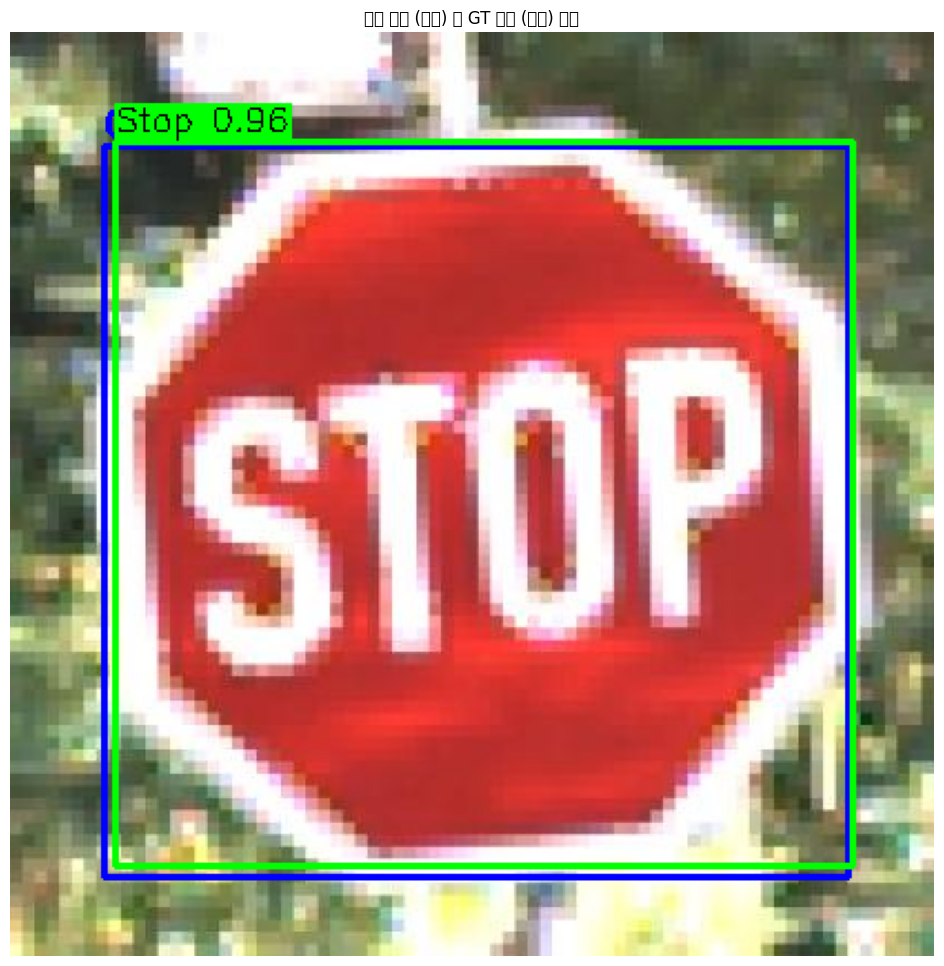

In [18]:
# üìå [9] ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è GT bboxÏôÄ ÎπÑÍµê Ìï®Ïàò Ï∂îÍ∞Ä
def draw_boxes_with_gt(image_path, pred_results, gt_label_path, class_names):
    img = cv2.imread(image_path)
    ih, iw = img.shape[:2]

    # GT Î∞ïÏä§ (ÌååÎûÄÏÉâ)
    with open(gt_label_path, 'r') as f:
        gt_lines = f.readlines()

    for line in gt_lines:
        cls, x, y, w, h = map(float, line.strip().split())
        x1 = int((x - w/2) * iw)
        y1 = int((y - h/2) * ih)
        x2 = int((x + w/2) * iw)
        y2 = int((y + h/2) * ih)
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(img, f"GT: {class_names[int(cls)]}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # ÏòàÏ∏° Î∞ïÏä§ (Ï¥àÎ°ùÏÉâ)
    for r in pred_results:
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy().astype(int)
        for (x1,y1,x2,y2), conf, cls in zip(boxes, scores, classes):
            label = f"{class_names[cls]} {conf:.2f}"
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(img, (x1, y1 - th - 5), (x1 + tw, y1), (0,255,0), -1)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("ÏòàÏ∏° Î∞ïÏä§ (Ï¥àÎ°ù) ÏôÄ GT Î∞ïÏä§ (ÌååÎûë) ÎπÑÍµê")
    plt.show()

gt_label_for_test_img = '../test/labels/00014_00004_00020_png.rf.e3b35f3ca153fde99af4db4a67d2a564.txt'
draw_boxes_with_gt(test_img, pred, gt_label_for_test_img, class_names)

In [40]:
# üìå [10] ONNX Î™®Îç∏Î°ú ÎÇ¥Î≥¥ÎÇ¥Í∏∞
export_path = model.export(format='onnx')
print(f"üß† ONNX Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú: {export_path}")

Ultralytics 8.3.156  Python-3.11.9 torch-2.7.1+cu128 CPU (13th Gen Intel Core(TM) i7-13700HX)

PyTorch: starting from 'runs\detect\yolov11n_custom_002\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success  2.7s, saved as 'runs\detect\yolov11n_custom_002\weights\best.onnx' (10.1 MB)

Export complete (3.3s)
Results saved to D:\Project\PJT_07\code\runs\detect\yolov11n_custom_002\weights
Predict:         yolo predict task=detect model=runs\detect\yolov11n_custom_002\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\yolov11n_custom_002\weights\best.onnx imgsz=640 data=data.yaml  
Visualize:       https://netron.app
üß† ONNX Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú: runs\detect\yolov11n_custom_002\weights\best.onnx


In [20]:
import os

Loading runs\detect\yolov11n_custom_003\weights\best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Stop, 37.7ms
Speed: 5.0ms preprocess, 37.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Project\PJT_07\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


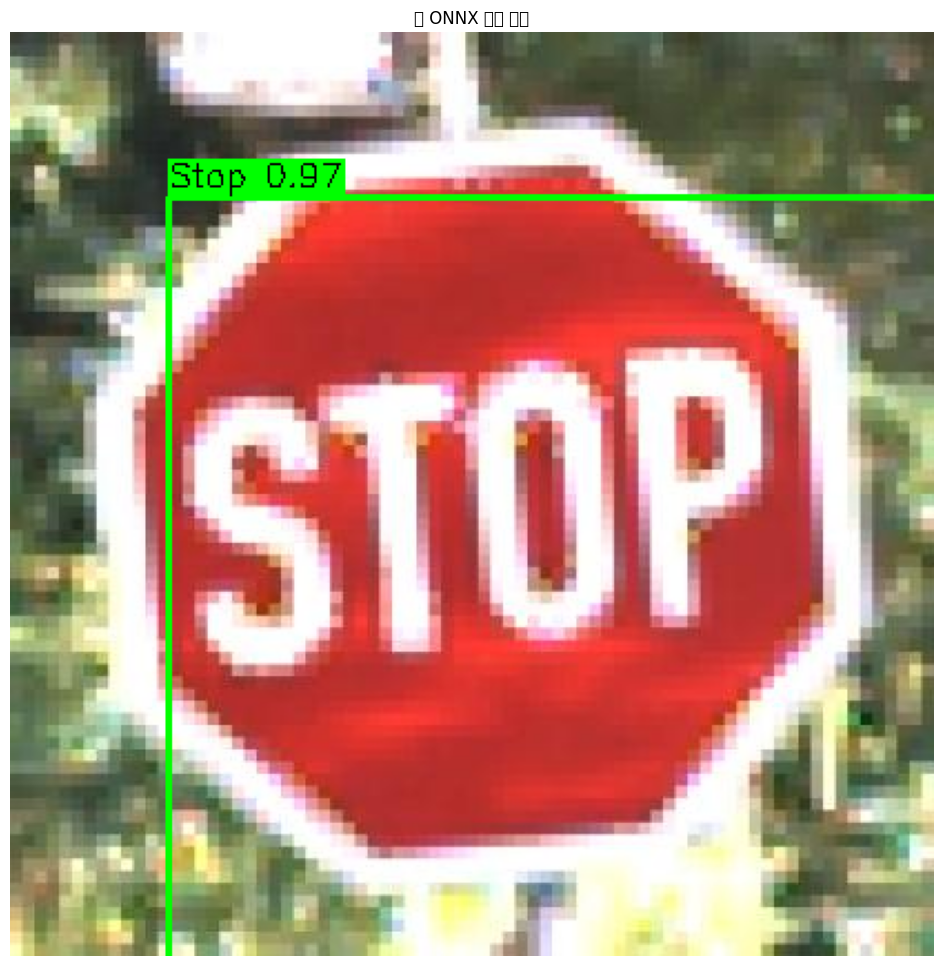

In [21]:
# üìå [11] ONNX Î™®Îç∏ Í∏∞Î∞ò ÏòàÏ∏° ÏãúÍ∞ÅÌôî (Í∏∞Ï°¥ ÏΩîÎìú Ïú†ÏßÄ)
onnx_model = YOLO(os.path.join('runs/detect', run_name, 'weights', 'best.onnx'))

image = cv2.imread(test_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (640, 640))

results_onnx = onnx_model(resized_image, imgsz=640)

for result in results_onnx:
    boxes = result.boxes
    names = result.names
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0]
        cls = int(box.cls[0])
        label = f"{names[cls]} {conf:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image, (x1, y1 - text_height - 5), (x1 + text_width, y1), (0, 255, 0), -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.title("üîç ONNX ÏòàÏ∏° Í≤∞Í≥º")
plt.show()

In [42]:
# print(df.columns)

In [24]:
import pandas as pd

print(run_name)

yolov11n_custom_003


üìà ÌõàÎ†® Í≤∞Í≥º ÏöîÏïΩ (EpochÎ≥Ñ mAP):
    metrics/mAP50(B)  metrics/mAP50-95(B)
25           0.93757              0.80491
26           0.93899              0.80909
27           0.94335              0.81435
28           0.94540              0.81500
29           0.94552              0.81616


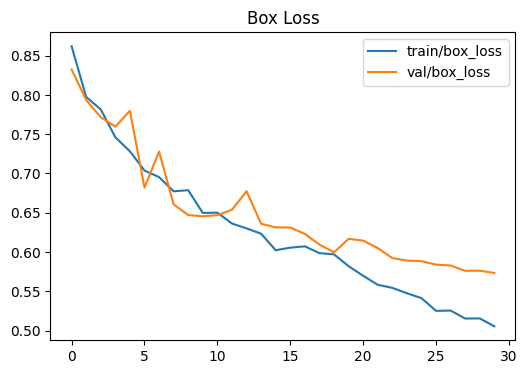

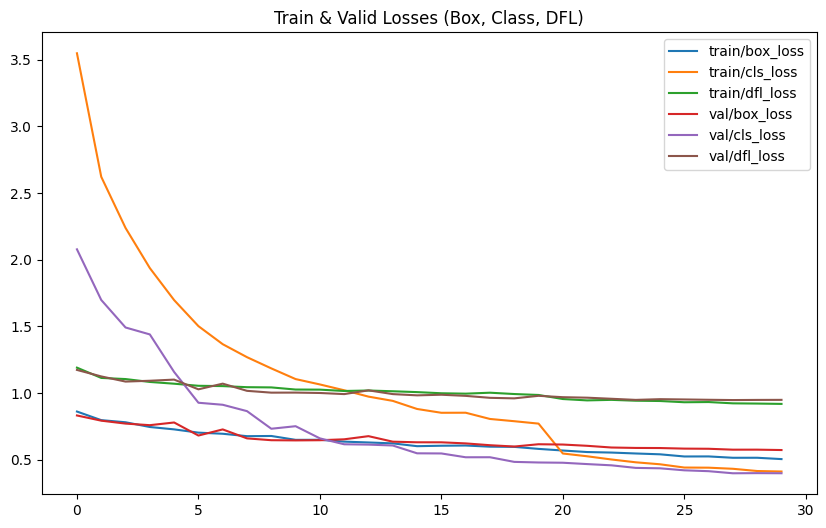

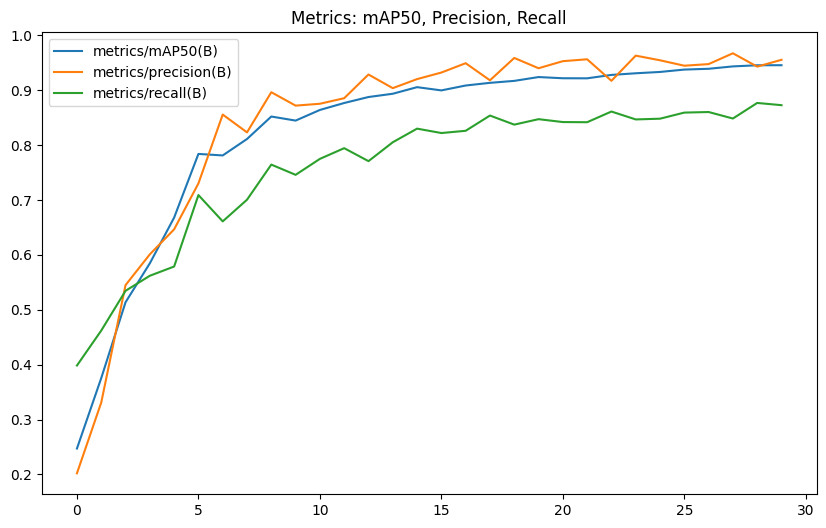

üéØ ÏµúÍ≥† ÏÑ±Îä• Epoch:
epoch                  30.00000
metrics/mAP50(B)        0.94552
metrics/mAP50-95(B)     0.81616
Name: 29, dtype: float64


In [25]:
# üìå [12] ÌõàÎ†® Í≤∞Í≥º ÏãúÍ∞ÅÌôî (mAP/Loss Îì±)
results_csv = f'runs/detect/{run_name}/results.csv'

if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    print(f"üìà ÌõàÎ†® Í≤∞Í≥º ÏöîÏïΩ (EpochÎ≥Ñ mAP):\n{df[['metrics/mAP50(B)', 'metrics/mAP50-95(B)']].tail()}")

    # Box Loss Í∑∏ÎûòÌîÑ
    df[['train/box_loss', 'val/box_loss']].plot(title='Box Loss', figsize=(6, 4))
    plt.savefig(f'runs/detect/{run_name}/box_loss.png')
    plt.show()

    # ‚úÖ ÏàòÏ†ï: train/valid Ï†ÑÏ≤¥ ÏÜêÏã§ ÏãúÍ∞ÅÌôî (box, cls, dfl)
    df[['train/box_loss', 'train/cls_loss', 'train/dfl_loss',
        'val/box_loss', 'val/cls_loss', 'val/dfl_loss']].plot(figsize=(10,6))
    plt.title('Train & Valid Losses (Box, Class, DFL)')
    plt.savefig(f'runs/detect/{run_name}/losses.png')
    plt.show()

    # mAP, Precision, Recall ÏãúÍ∞ÅÌôî
    df[['metrics/mAP50(B)', 'metrics/precision(B)', 'metrics/recall(B)']].plot(figsize=(10,6))
    plt.title('Metrics: mAP50, Precision, Recall')
    plt.savefig(f'runs/detect/{run_name}/metrics.png')
    plt.show()

    best_idx = df['metrics/mAP50-95(B)'].idxmax()
    print("üéØ ÏµúÍ≥† ÏÑ±Îä• Epoch:")
    print(df.loc[best_idx, ['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']])
else:
    print("üìõ results.csv ÏóÜÏùå (ÌõàÎ†® Ïã§Ìå®?)")

In [27]:
import json

In [28]:
# üìå [13] Í≤∞Í≥ºÎ•º JSONÏúºÎ°ú Ï†ÄÏû•
def save_results_to_json(csv_path, json_path):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        result_data = df.to_dict(orient='records')
        with open(json_path, 'w') as f:
            json.dump(result_data, f, indent=4)
        print(f"üì¶ Í≤∞Í≥º JSON Ï†ÄÏû• ÏôÑÎ£å: {json_path}")

save_results_to_json(
    csv_path=f'runs/detect/{run_name}/results.csv',
    json_path=f'runs/detect/{run_name}/results_summary.json'
)

üì¶ Í≤∞Í≥º JSON Ï†ÄÏû• ÏôÑÎ£å: runs/detect/yolov11n_custom_003/results_summary.json
